# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

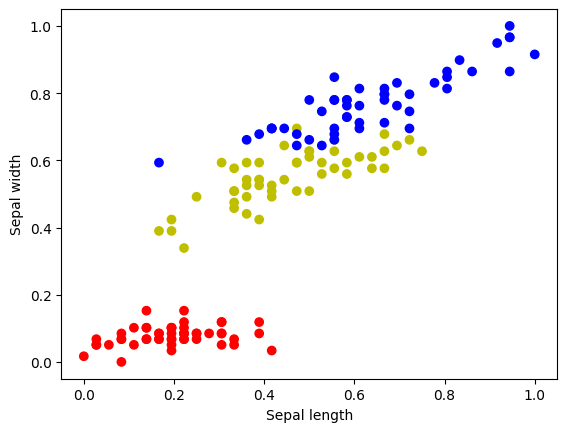

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
X_tensor

tensor([[0.2222, 0.0678],
        [0.1667, 0.0678],
        [0.1111, 0.0508],
        [0.0833, 0.0847],
        [0.1944, 0.0678],
        [0.3056, 0.1186],
        [0.0833, 0.0678],
        [0.1944, 0.0847],
        [0.0278, 0.0678],
        [0.1667, 0.0847],
        [0.3056, 0.0847],
        [0.1389, 0.1017],
        [0.1389, 0.0678],
        [0.0000, 0.0169],
        [0.4167, 0.0339],
        [0.3889, 0.0847],
        [0.3056, 0.0508],
        [0.2222, 0.0678],
        [0.3889, 0.1186],
        [0.2222, 0.0847],
        [0.3056, 0.1186],
        [0.2222, 0.0847],
        [0.0833, 0.0000],
        [0.2222, 0.1186],
        [0.1389, 0.1525],
        [0.1944, 0.1017],
        [0.1944, 0.1017],
        [0.2500, 0.0847],
        [0.2500, 0.0678],
        [0.1111, 0.1017],
        [0.1389, 0.1017],
        [0.3056, 0.0847],
        [0.2500, 0.0847],
        [0.3333, 0.0678],
        [0.1667, 0.0847],
        [0.1944, 0.0339],
        [0.3333, 0.0508],
        [0.1667, 0.0678],
        [0.0

In [5]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [6]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [7]:
model.state_dict()    # 'weight': é uma matriz de 3x2, já que temos 3 neurônios (saídas) e 2 entradas. Cada linha corresponde aos pesos de um neurônio.

                      # 'bias': é um vetor de 3 elementos, o bias adicionado a cada saída.

OrderedDict([('weight',
              tensor([[ 0.2660,  0.2070],
                      [-0.0292, -0.1571],
                      [ 0.1441,  0.6921]])),
             ('bias', tensor([ 0.6417, -0.2643,  0.4859]))])

os pesos e os bias são automaticamente inicializados pelo PyTorch.

Isso significa que, mesmo antes de treinar o modelo, o PyTorch já define valores iniciais para os parâmetros da rede. Esses valores iniciais são normalmente aleatórios, seguindo alguma distribuição estatística específica (por exemplo, distribuição uniforme ou normal, dependendo do tipo de inicialização).

✨ Por que o PyTorch faz isso?

Porque, para começar o treinamento (fazer o ajuste dos pesos), os parâmetros não podem começar valendo zero ou indefinidos. Eles precisam ter algum valor inicial para que o algoritmo de otimização (como o gradiente descendente) saiba de onde começar a ajustar.

### Fazendo um predict

In [8]:
# gera logits (saídas ainda não normalizadas(ainda não são probabilidades.) - antes de aplicar uma função de ativação como softmax) para as 4 primeiras amostras.
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[ 0.7149, -0.2814,  0.5648],
        [ 0.7001, -0.2798,  0.5568],
        [ 0.6818, -0.2755,  0.5371],
        [ 0.6814, -0.2800,  0.5565]], grad_fn=<AddmmBackward0>)

In [9]:
# Para transformar logits em probabilidades, usamos a função softmax
oo = F.softmax(out,dim=1)
oo

tensor([[0.4484, 0.1656, 0.3860],
        [0.4461, 0.1674, 0.3865],
        [0.4446, 0.1707, 0.3847],
        [0.4415, 0.1688, 0.3897]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [10]:
F.softmax(out,dim=1)*100     # aplica a função softmax ao longo da dimensão das colunas (dim=1), ou seja, para cada linha da matriz out, transforma os logits em probabilidades.

tensor([[44.8449, 16.5591, 38.5961],
        [44.6057, 16.7431, 38.6511],
        [44.4606, 17.0697, 38.4697],
        [44.1516, 16.8810, 38.9674]], grad_fn=<MulBackward0>)

### Predição da classe

In [11]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1) # A função torch.max retorna o maior valor ao longo de um eixo (no caso, dim=1 → ao longo das colunas, ou seja, por linha).
print(y_pred)
print(prob)

tensor([0, 0, 0, 0])
tensor([0.4484, 0.4461, 0.4446, 0.4415], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [12]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr) # Você está dizendo: "Eu quero usar o SGD para atualizar os parâmetros do meu modelo, com uma taxa de aprendizado lr."
criterion = nn.CrossEntropyLoss() # Ela mede quão longe a saída do seu modelo (as probabilidades) está da resposta correta (label verdadeiro).Você está dizendo: "Eu quero medir o erro do meu modelo usando a Cross-Entropy Loss."



Final loss: 0.20649677515029907


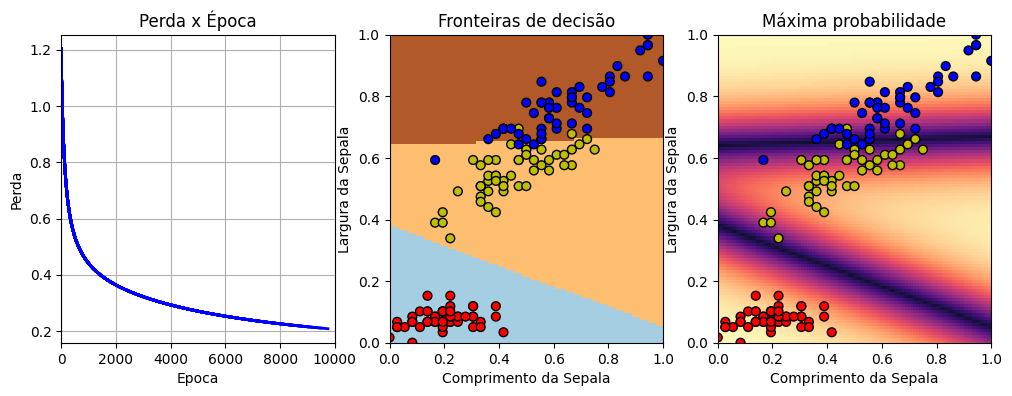

In [ ]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.7633, -14.7924],
                      [  1.7349,  -0.6748],
                      [  1.2195,  15.3744]])),
             ('bias', tensor([ 7.3976,  2.0729, -8.1821]))])

### Salvando os parâmetros treinados

In [ ]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [ ]:
! ls ../models/

RegrLog_Iris.pt


In [ ]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-17-0d5512203613>:1: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 7.3976,  2.0729, -8.1821]))])

### Recuperando os pesos salvos

In [ ]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.7633, -14.7924],
                      [  1.7349,  -0.6748],
                      [  1.2195,  15.3744]])),
             ('bias', tensor([ 7.3976,  2.0729, -8.1821]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [ ]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

2. Experimente refazer o treinamento com diferentes valores de learning rate

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


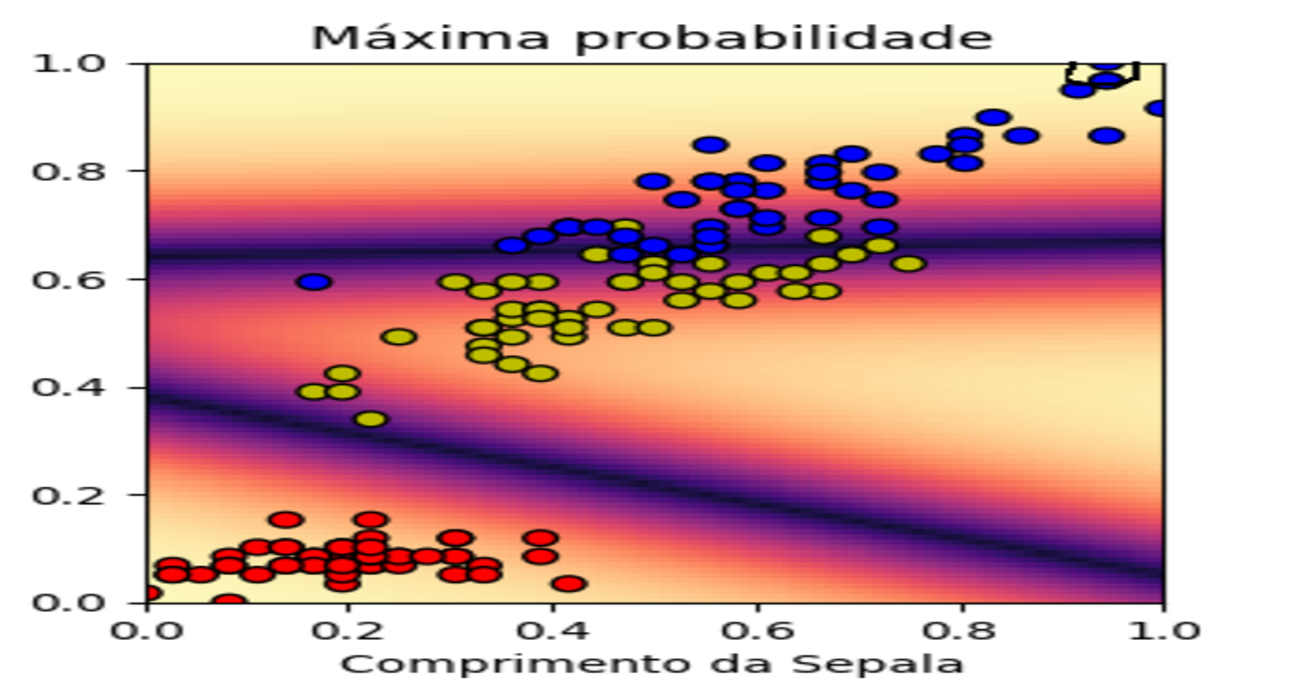

In [16]:
# 1.1
from IPython.display import Image
Image('/content/drive/My Drive/1.png')

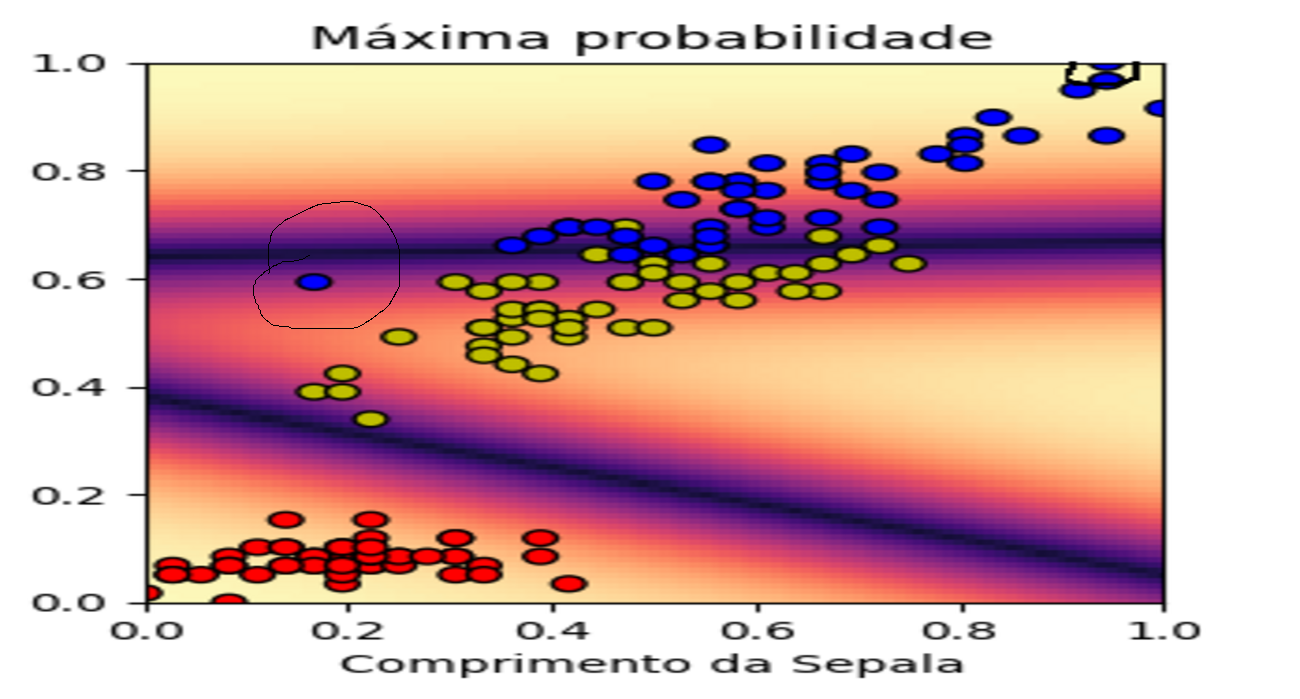

In [17]:
# 1.2
from IPython.display import Image
Image('/content/drive/My Drive/2.png')

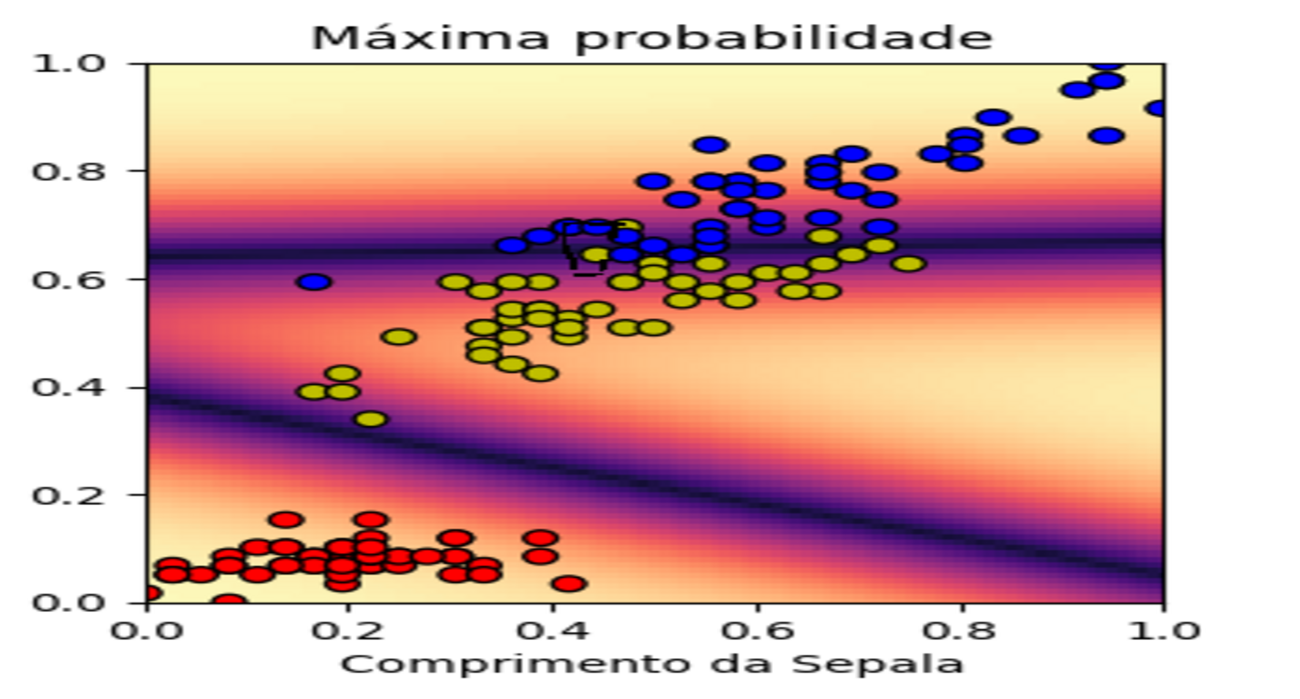

In [18]:
# 1.3
from IPython.display import Image
Image('/content/drive/My Drive/3.png')

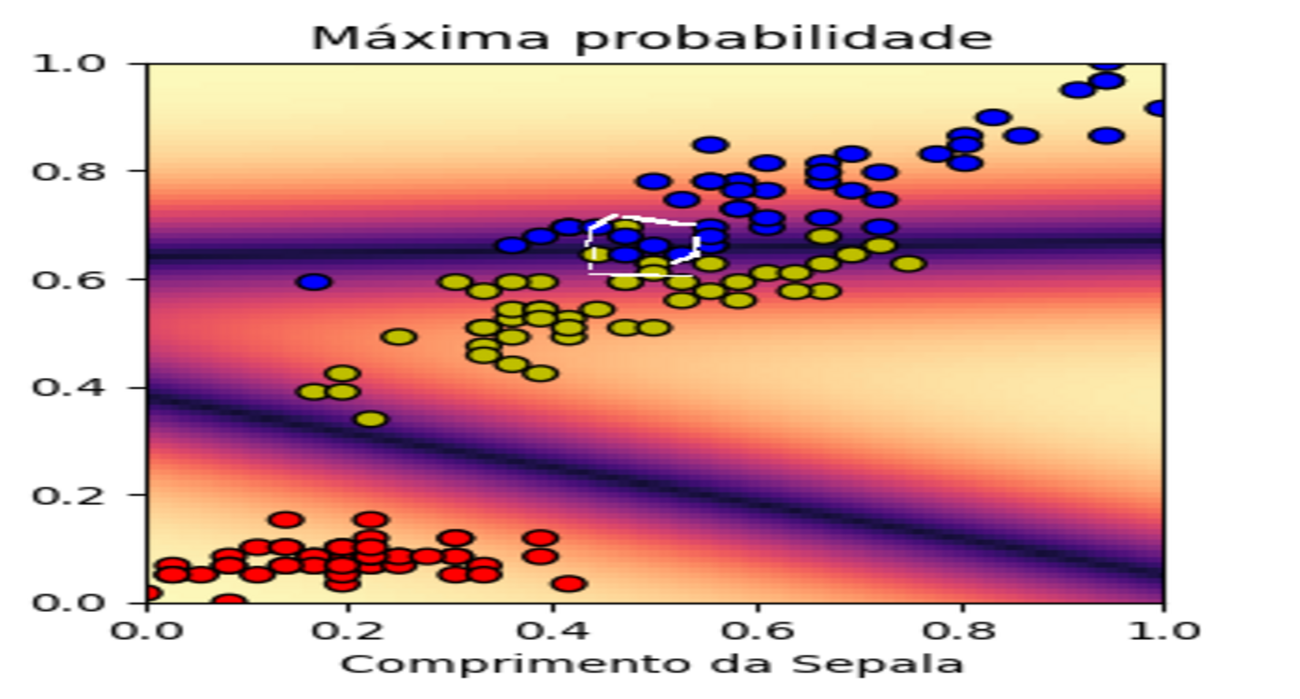

In [19]:
# 1.4
from IPython.display import Image
Image('/content/drive/My Drive/4.png')

In [25]:
# 2.
total_params = sum(p.numel() for p in model.parameters())
total_params
for name, param in model.named_parameters():
    print(f"Nome: {name}")
    print(f"Shape: {param.shape}")
    print(f"Número de parâmetros: {param.numel()}")
    print()
print(f"{sum(p.numel() for p in model.parameters())} parâmetros")

Nome: weight
Shape: torch.Size([3, 2])
Número de parâmetros: 6

Nome: bias
Shape: torch.Size([3])
Número de parâmetros: 3

9 parâmetros


In [26]:
# 3.
# comprimento e largura da sépala
print("Número de entradas:", model.in_features)

# classes do irirs
print("Número de saídas:", model.out_features)


Número de entradas: 2
Número de saídas: 3


In [ ]:
# 4.

In [28]:
print(f"Somar os valores da diagonal principal e dividir essa soma pela soma de todos os valores da matriz.")

Somar os valores da diagonal principal e dividir essa soma pela soma de todos os valores da matriz.


In [30]:
# 5.
print(f"A função torch.max retorna o maior valor ao longo de um eixo (no caso, dim=1 → ao longo das colunas, ou seja, por linha)")

prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

print(f"Retorna a maior probabilidade de uma entrada pertencer a uma determinada classe")



A função torch.max retorna o maior valor ao longo de um eixo (no caso, dim=1 → ao longo das colunas, ou seja, por linha)
tensor([0, 0, 0, 0])
tensor([0.4484, 0.4461, 0.4446, 0.4415], grad_fn=<MaxBackward0>)
Retorna a maior probabilidade de uma entrada pertencer a uma determinada classe


## Principais aprendizados